<a href="https://colab.research.google.com/github/czheng10/multimodal-AVIDDA/blob/main/68510FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation of Software and Packages

Note: Importing mediapipe may cause some issues, please restart the runtime and run all cells again.

In [ ]:
import cv2
import os
import numpy as np
from datetime import datetime
import os
import math
from joblib import dump, load
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/AssemblyAI-Examples/mediapipe-python.git
!pip uninstall -y mediapipe
!pip install mediapipe --upgrade

fatal: destination path 'mediapipe-python' already exists and is not an empty directory.
Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21
  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)


In [ ]:
import mediapipe as mp

# Video Processing
The following section performs preprocessing on the SUST-DDD dataset to create frames, and creates our testing and training datasets. We use 100 videos of drowsy and 100 of nondrowsy.


In [ ]:
!git clone https://github.com/EsraKavalci/Sivas-University-of-Science-and-Technology-Driver-Drowsiness-Dataset.git

# define paths to subdir
DROWSY_PATH = "/content/Sivas-University-of-Science-and-Technology-Driver-Drowsiness-Dataset/SUST Driver Drowsiness Dataset/drowsiness/"
NONDROWSY_PATH = "/content/Sivas-University-of-Science-and-Technology-Driver-Drowsiness-Dataset/SUST Driver Drowsiness Dataset/not drowsiness/"

fatal: destination path 'Sivas-University-of-Science-and-Technology-Driver-Drowsiness-Dataset' already exists and is not an empty directory.


In [ ]:
RATIO = 0.8 # Test-train ratio
DATA_SET_SIZE = 100
VALIDATION_SET_SIZE = 100
FRAMES = 240
TRAIN_PATH = "/content/drive/My Drive/multimodal/train/"
TEST_PATH = "/content/drive/My Drive/multimodal/test/"
VALIDATION_PATH = "/content/drive/My Drive/multimodal/validate/"
mapping = {'d': "drowsy", 'n':"nondrowsy"}

In [ ]:
def split_data(input_path, train_path, test_path, ratio= 0.8, size=100, frames = 240):
  """
  Given input and output paths, takes all videos from input_path, breaks them down into frames, and
  stores them in train and test path based on ratio
  """
  DEBUG = True
  os.makedirs(train_path, exist_ok=True)
  os.makedirs(test_path, exist_ok=True)

  videos = [f for f in os.listdir(input_path) if f.endswith('.mp4')]
  videos = videos[:size]
  train_count = int(ratio*len(videos))
  # iterate through videos
  for idx, video in enumerate(videos):

    # train test divide + make folder
    if idx < train_count:
        video_folder = os.path.join(train_path, mapping[video[0]], video.split('.')[0])
    else:
        video_folder = os.path.join(test_path, mapping[video[0]], video.split('.')[0])
    os.makedirs(video_folder, exist_ok=True)
    if DEBUG:
      print(f'output folder path is {video_folder}')

    # normalize # of frames
    cap = cv2.VideoCapture(os.path.join(input_path,video))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, frame_count - 1, frames, dtype=int)
    # write frames to drive
    for x, i in enumerate(indices):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()
      if ret:
        img_path = os.path.join(video_folder, str(x) + '.jpg')
        success = cv2.imwrite(img_path, frame)
        if DEBUG and not success:
            print(f'frame failed')
      else:
          break
    cap.release()
  return

In [ ]:
def split_val_data(input_path_drowsy, input_path_nondrowsy, val_path, existing_drowsy, existing_nondrowsy, size = 20, frames = 240):
  """
  Given input and output paths, takes all videos from input_path, breaks them down into frames, and
  stores them in val_path
  """
  DEBUG = True
  os.makedirs(val_path, exist_ok=True)

  # collect existing data
  existing_drowsy_drivers = set()
  for folder in existing_drowsy:
    for driver in os.listdir(folder):
      driver_id = driver.split("_")[-1]
      existing_drowsy_drivers.add(driver_id)

  existing_nondrowsy_drivers = set()
  for folder in existing_nondrowsy:
    for driver in os.listdir(folder):
      driver_id = driver.split("_")[-1]
      existing_nondrowsy_drivers.add(driver_id)

  drowsy = [f for f in os.listdir(input_path_drowsy) if f.endswith('.mp4') and os.path.splitext(f)[0].split('_')[-1] not in existing_drowsy_drivers]
  drowsy = drowsy[:10]
  nondrowsy = [f for f in os.listdir(input_path_nondrowsy) if f.endswith('.mp4') and os.path.splitext(f)[0].split('_')[-1] not in existing_nondrowsy_drivers]
  nondrowsy = nondrowsy[:10]

  # iterate through drowsy videos
  for idx, video in enumerate(drowsy):
    video_folder = os.path.join(val_path,  mapping[video[0]], video.split('.')[0])
    os.makedirs(video_folder, exist_ok=True)
    if DEBUG:
      print(f'output folder path is {video_folder}')

    # normalize # of frames
    cap = cv2.VideoCapture(os.path.join(input_path_drowsy,video))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, frame_count - 1, frames, dtype=int)
    # write frames to drive
    for x, i in enumerate(indices):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()
      if ret:
        img_path = os.path.join(video_folder, str(x) + '.jpg')
        success = cv2.imwrite(img_path, frame)
        if DEBUG and not success:
            print(f'frame failed')
      else:
          break
    cap.release()

  # iterate through nondrowsy videos
  for idx, video in enumerate(nondrowsy):
    video_folder = os.path.join(val_path,  mapping[video[0]], video.split('.')[0])
    os.makedirs(video_folder, exist_ok=True)
    if DEBUG:
      print(f'output folder path is {video_folder}')

    # normalize # of frames
    cap = cv2.VideoCapture(os.path.join(input_path_nondrowsy,video))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, frame_count - 1, frames, dtype=int)
    # write frames to drive
    for x, i in enumerate(indices):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()
      if ret:
        img_path = os.path.join(video_folder, str(x) + '.jpg')
        success = cv2.imwrite(img_path, frame)
        if DEBUG and not success:
            print(f'frame failed')
      else:
          break
    cap.release()
  return

The following two split_data calls split the SUST-DDD dataset following the ratio. Note that this will take around 4 hours per call. These only need to be ran once and stored to drive.

In [ ]:
# # Split drowsy data
# split_data(DROWSY_PATH, TRAIN_PATH, TEST_PATH, RATIO, DATA_SET_SIZE, FRAMES)

In [ ]:
# # Split nondrowsy data
# split_data(NONDROWSY_PATH, TRAIN_PATH, TEST_PATH, RATIO, DATA_SET_SIZE)

In [ ]:
train_drowsy = "/content/drive/My Drive/multimodal/train/drowsy"
test_drowsy = "/content/drive/My Drive/multimodal/test/drowsy"
train_nondrowsy = "/content/drive/My Drive/multimodal/train/nondrowsy"
test_nondrowsy = "/content/drive/My Drive/multimodal/test/nondrowsy"

In [ ]:
val_drowsy = "/content/drive/My Drive/multimodal/validate/drowsy"
val_nondrowsy = "/content/drive/My Drive/multimodal/validate/nondrowsy"

In [ ]:
# # Split validation data
# split_val_data(DROWSY_PATH, NONDROWSY_PATH, VALIDATION_PATH, [train_drowsy, test_drowsy], [train_nondrowsy, test_nondrowsy])

# Initializing Mediapipe Solutions

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
mp_pose = mp.solutions.pose

# Feature Detection

In [ ]:
#identify which indices of the facemesh correspond to eyes, as opposed to face
EYE_IDX = set()
for i in mp_face_mesh.FACEMESH_IRISES:
  EYE_IDX.add(i[0])
  EYE_IDX.add(i[1])
for i in mp_face_mesh.FACEMESH_LEFT_EYE:
  EYE_IDX.add(i[0])
  EYE_IDX.add(i[1])
for i in mp_face_mesh.FACEMESH_RIGHT_EYE:
  EYE_IDX.add(i[0])
  EYE_IDX.add(i[1])

# specify UPPER body pose points
POSE_IDX = [mp_pose.PoseLandmark.NOSE, \
            mp_pose.PoseLandmark.LEFT_EAR, mp_pose.PoseLandmark.RIGHT_EAR, \
            mp_pose.PoseLandmark.MOUTH_LEFT, mp_pose.PoseLandmark.MOUTH_RIGHT, \
            mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER]

FACE_NO_EYES_LEN = 438

In [ ]:
def extract_features_by_sample(sample):
  """
  given just one sample, extract the features of EYE (iris), HEAD, POSE from that sample
  """
  eye = []
  head = []
  pose =[]
  sorted_sample = sorted(os.listdir(sample), key=lambda x: int(x.split('.')[0]))
  with mp_face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        refine_landmarks=True) as face_mesh, \
        mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1) as pose_mesh:
        for img in sorted_sample:
          frame = cv2.imread(os.path.join(sample, img))

          eye_features = []
          head_features = []
          face_results = face_mesh.process(frame)
          if face_results.multi_face_landmarks:
            landmarks = face_results.multi_face_landmarks[0].landmark
            for idx, landmark in enumerate(landmarks):
              if idx in EYE_IDX:
                eye_features.append([landmark.x, landmark.y, landmark.z])
              else:
                head_features.append([landmark.x, landmark.y, landmark.z])

          pose_features = []
          pose_results = pose_mesh.process(frame)
          if pose_results.pose_landmarks:
            for i, landmark in enumerate(pose_results.pose_landmarks.landmark):
              if i in POSE_IDX:
                pose_features.append([landmark.x, landmark.y, landmark.z])
          eye.append(eye_features)
          head.append(head_features)
          pose.append(pose_features)
  return eye, head, pose


In [ ]:
def extract_all_features(path):
  """
  given a path to all samples, runs feature extraction
  """
  eyes = []
  heads = []
  poses = []
  for dir in os.listdir(path):
    e, h, p = extract_features_by_sample(os.path.join(path, dir))
    eyes.append(e)
    heads.append(h)
    poses.append(p)
    print(dir, " done")
  return eyes, heads, poses

In [ ]:
# training_data_nondrowsy = extract_all_features(train_nondrowsy)
# train_n_eye = training_data_nondrowsy[0]
# train_n_head = training_data_nondrowsy[1]
# train_n_pose = training_data_nondrowsy[2]

In [ ]:
# # 3 by 80
# training_data_drowsy = extract_all_features(train_drowsy)
# train_d_eye = training_data_drowsy[0]
# train_d_head = training_data_drowsy[1]
# train_d_pose = training_data_drowsy[2]

In [ ]:
# val_data_drowsy = extract_all_features(val_drowsy)
# val_d_eye = val_data_drowsy[0]
# val_d_head = val_data_drowsy[1]
# val_d_pose = val_data_drowsy[2]

In [ ]:
# val_data_nondrowsy = extract_all_features(val_nondrowsy)
# val_n_eye = val_data_nondrowsy[0]
# val_n_head = val_data_nondrowsy[1]
# val_n_pose = val_data_nondrowsy[2]

In [ ]:
# train_eye_x, train_eye_y = prepare_data(train_d_eye, train_n_eye, len(EYE_IDX))
# train_head_x, train_head_y = prepare_data(train_d_head, train_n_head, FACE_NO_EYES_LEN)
# train_pose_x, train_pose_y = prepare_data(train_d_pose, train_n_pose, len(POSE_IDX))

# val_eye_x, val_eye_y = prepare_data(val_d_eye, val_n_eye, len(EYE_IDX))
# val_head_x, val_head_y = prepare_data(val_d_head, val_n_head, FACE_NO_EYES_LEN)
# val_pose_x, val_pose_y = prepare_data(val_d_pose, val_n_pose, len(POSE_IDX))

In [ ]:
# from google.colab import files
# dump((train_eye_x, train_eye_y, train_head_x, train_head_y, train_pose_x, train_pose_y), 'traindata.joblib')
# dump((val_eye_x, val_eye_y,val_head_x, val_head_y, val_pose_x, val_pose_y), 'valdata.joblib')
# files.download('traindata.joblib')
# files.download('valdata.joblib')

In [ ]:
train_eye_x, train_eye_y, train_head_x, train_head_y, train_pose_x, train_pose_y = load('/content/drive/My Drive/multimodal/traindata.joblib')
val_eye_x, val_eye_y,val_head_x, val_head_y, val_pose_x, val_pose_y = load('/content/drive/My Drive/multimodal/valdata.joblib')
test_eye_x, test_eye_y,test_head_x, test_head_y,test_pose_x, test_pose_y = load('/content/drive/My Drive/multimodal/testdata.joblib')

# Training

Here we implement Sci-kit Learn's AdaBoost Classifier. Our choice of weak learners are Decision Tree's with a depth of 1. Other parameters are chosen empirically, and shown below. Here, a label of 1 = drowsy, and a label of 0 = nondrowsy.

In [ ]:
from joblib import dump, load
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from google.colab import files

In [ ]:
def prepare_data(drowsy, nondrowsy, features):
  """
  Given the drowsy and nondrowsy datasets, returns the X and Y data points ready for training
  Note that drowsy = 1, nondrowsy = 0
  removes frames where there are no features detected
  """
  x = []
  y = [1]*len(drowsy)+[0]*len(nondrowsy)
  padding = np.zeros((features, 3))
  lengths = set()
  for i in drowsy:
    sample = []
    for frame in i:
      if len(frame):
        sample.append(frame)
      else:
        sample.append(padding)
    x.append(sample)
  for i in nondrowsy:
    sample = []
    for frame in i:
      if len(frame):
        sample.append(frame)
      else:
        sample.append(padding)
    x.append(sample)
  arr_x = np.array(x)
  return arr_x.reshape(arr_x.shape[0], -1), np.array(y)

In [ ]:
def create_model(n = 30, lr = 0.1, max_depth = 1):
  """
  Given the number of weak learners and the learning rate, creates an Adaboost
  classifier with DecisionTreeClassifiers as the weak learner
  """
  classifier = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = 5, min_samples_split =10),
        n_estimators=n,
        learning_rate=lr
    )

  return classifier

The following method trains our three models. This part will take about 35 minutes.

In [ ]:
def train_models(train_eye_x, train_eye_y, train_head_x, train_head_y, train_pose_x, train_pose_y):
  """
  Given both drowsy and nondrowsy EYE, HEAD, POSE data, train 3 AdaBoost classifiers
  """
  e_c = create_model(n = 100, lr = 0.1)
  e_c.fit(train_eye_x, train_eye_y)
  dump(e_c, 'eye_model.joblib')
  print("eye done")

  h_c = create_model(n = 150, lr = 0.1)
  h_c.fit(train_head_x, train_head_y)
  dump(h_c, 'head_model.joblib')
  print("head done")

  p_c = create_model(n = 100, lr = 0.1)
  p_c.fit(train_pose_x, train_pose_y)
  dump(p_c, 'upperbodypose_model.joblib')
  print("pose done")

In [ ]:
train_models(train_eye_x, train_eye_y, train_head_x, train_head_y, train_pose_x, train_pose_y)

eye done


In [ ]:
files.download('eye_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('head_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('upperbodypose_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Weighted Combination

Now that the three models are trained, in this section, we determine the best possible weighted combination of their predictions.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split

In [ ]:
def load_models():
  eye = load('/content/drive/My Drive/multimodal/eye_model-100-0.1-spec2.joblib')
  head = load('/content/drive/My Drive/multimodal/head_model-spec.joblib')
  pose = load('/content/drive/My Drive/multimodal/upperbodypose_model-spec.joblib')
  return eye, head, pose

In [ ]:
def get_probs(sample_eye, sample_head, sample_pose):
  eye_pred = e.predict_proba([sample_eye])
  head_pred = h.predict_proba([sample_head])
  pose_pred = p.predict_proba([sample_pose])
  return eye_pred, head_pred, pose_pred

In [ ]:
e, h, p = load_models()
X_train = np.zeros((160,3))
X_val = np.zeros((20,3))
y_train = np.zeros((160,1))
y_val = np.zeros((20,1))
X_eye = np.zeros((160,1))
X_head = np.zeros((160,1))
X_pose = np.zeros((160,1))

for i, [sample_eye, sample_head, sample_pose] in enumerate(zip(val_eye_x, val_head_x, val_pose_x)):
  eye_p, head_p, pose_p = get_probs(sample_eye, sample_head, sample_pose)
  X_val[i] = [eye_p[0][1], head_p[0][1], pose_p[0][1]]
  y_val[i] = [val_eye_y[i]]

for j, [sample_eye, sample_head, sample_pose] in enumerate(zip(train_eye_x, train_head_x, train_pose_x)):
  eye_p, head_p, pose_p = get_probs(sample_eye, sample_head, sample_pose)
  X_train[j] = [eye_p[0][1], head_p[0][1], pose_p[0][1]]
  X_eye[j] = eye_p[0][1]
  X_head[j] = head_p[0][1]
  X_pose[j] = pose_p[0][1]
  y_train[j] = [train_eye_y[j]]

clf = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs')
clf.fit(X_train, y_train)

print("raw weights:", clf.coef_[0], "bias:", clf.intercept_[0])

val_auc = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
print("val AUC:", val_auc)

raw_weights = clf.coef_[0]

weights = np.array([raw_weights[0], raw_weights[1], raw_weights[2]])
offset = clf.intercept_[0]

X_train_bin = (X_train @ weights + offset >= 0.5).astype(int)
print("EYE ACCURACY: ", accuracy_score(y_train, (X_eye > 0.5).astype(int)))
print("HEAD ACCURACY: ", accuracy_score(y_train, (X_head> 0.5).astype(int)))
print("POSE ACCURACY: ", accuracy_score(y_train, (X_pose> 0.5).astype(int)))

raw weights: [1.87858007 3.86422247 3.73796147] bias: -4.839405413695547
val AUC: 0.78
EYE ACCURACY:  0.6875
HEAD ACCURACY:  0.93125
POSE ACCURACY:  0.86875


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
X_val_sig = sigmoid(X_val @ weights + offset)
print(X_val_sig)

[0.55183963 0.46221385 0.62995913 0.65349219 0.56460893 0.70507326
 0.26653004 0.52960013 0.25238652 0.65348451 0.22507924 0.37724638
 0.29845888 0.40599846 0.29704163 0.59508175 0.53036705 0.34424714
 0.29829927 0.24940559]


# Threshold Determination
In the following section, we determine the threshold between classification as drowsy versus non-drowsy, such that we balance the effects of false positives and false negatives.

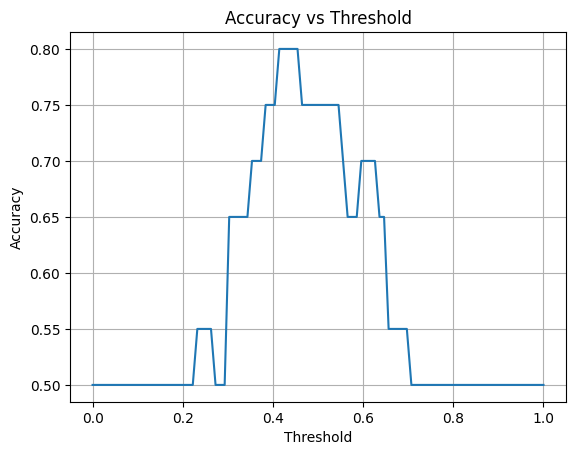

BEST THRESHOLD: 0.4545454545454546


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Suppose:
# y_true = np.array([...])  # True labels (0 or 1)
# y_scores = np.array([...])  # Predicted scores/probabilities

thresholds = np.linspace(0, 1, 100)
accuracies = []
highest_acc = -float('inf')
THRESHOLD = thresholds[0]
for thresh in thresholds:
  y_pred = (X_val_sig >= thresh).astype(int)
  if accuracy_score(y_val, y_pred) >= highest_acc:
    THRESHOLD = thresh
    highest_acc = accuracy_score(y_val, y_pred)
  accuracies.append(accuracy_score(y_val, y_pred))

# Plot F1 vs Threshold
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid()
plt.show()
print("BEST THRESHOLD:", THRESHOLD)

# Preparing the Testing Data

In [ ]:
# test_d_eye, test_d_head, test_d_pose = extract_all_features(test_drowsy)
# test_n_eye, test_n_head, test_n_pose = extract_all_features(test_nondrowsy)

In [ ]:
# test_eye_x, test_eye_y = prepare_data(test_d_eye, test_n_eye, len(EYE_IDX))
# test_head_x, test_head_y = prepare_data(test_d_head, test_n_head, FACE_NO_EYES_LEN)
# test_pose_x, test_pose_y = prepare_data(test_d_pose, test_n_pose, len(POSE_IDX))

In [ ]:
# dump((test_eye_x, test_eye_y,test_head_x, test_head_y,test_pose_x, test_pose_y), 'testdata.joblib')
# files.download('testdata.joblib')

# Evaluation

In this section, we seek to evaluate our models' performance and accuracy.

For performance, we compute

1. the average prediction time
2. the average time it takes for data preprocessing and feature extraction
3. the average time it takes to go through the entire process (from the moment the recording is produced to the moment the alert is triggered).

For accuracy we compute/generate

1. the prediction accuracy on 40 unseen data samples
2. the prediction accuracy on positive samples (20)
3. the prediction accuracy on negative samples (20)
4. the prediction recall curve and the AUC score
5. the confusion matrix



# Testing

In [ ]:
from sklearn.metrics import accuracy_score
X_test = np.zeros((40, 3))
y_test = np.zeros((40,1))
for i, [sample_eye, sample_head, sample_pose] in enumerate(zip(test_eye_x, test_head_x, test_pose_x)):
  eye_p, head_p, pose_p = get_probs(sample_eye, sample_head, sample_pose)
  X_test[i] = [eye_p[0][1], head_p[0][1], pose_p[0][1]]
  y_test[i] = [test_eye_y[i]]
X_test = X_test @ weights + offset
X_test = sigmoid(X_test)
X_test_bin = (X_test > 0.59).astype(int)
acc = accuracy_score(y_test, X_test_bin)

In [ ]:
print(X_test)

[0.56946192 0.29937011 0.81349797 0.30036862 0.71248733 0.67415039
 0.64840499 0.63805023 0.80630251 0.60768768 0.75216525 0.63217597
 0.41929498 0.44729535 0.70674206 0.33288079 0.69527852 0.3824335
 0.61657518 0.59865403 0.78086693 0.19960149 0.45954438 0.66951357
 0.51757922 0.55998769 0.73518763 0.47474967 0.40042842 0.21607898
 0.54692894 0.62312664 0.32620193 0.57975984 0.25351585 0.24038883
 0.52343606 0.43405884 0.46698607 0.72278828]


In [ ]:
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.7000


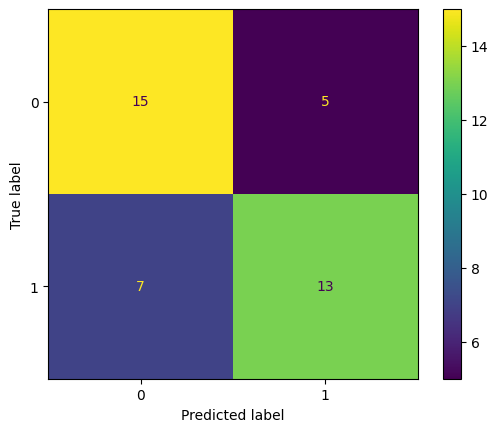

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, X_test_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

AUC = 0.7000


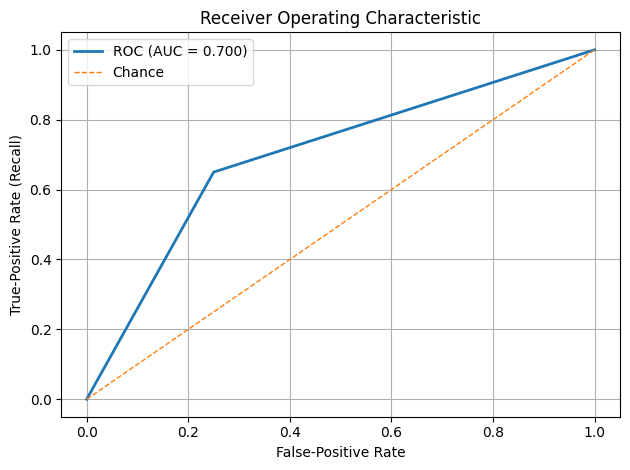

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


false_pos, true_pos, _ = roc_curve(y_test, X_test_bin)
auc   = roc_auc_score(y_test, X_test_bin)
print(f"AUC = {auc:.4f}")

# ----------------------------------------------------
# 4. Plot
# ----------------------------------------------------
plt.figure()
plt.plot(false_pos, true_pos, lw=2, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Chance")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()